<a href="https://colab.research.google.com/github/oduolaidrisA/Machine-Learning/blob/main/quantum_oscillator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Consider the problem defined as:

\begin{equation}
-\frac{\hbar^2}{2m} \frac{d^2  \psi}{dx^2}  + V(x) \psi =  E \psi
\end{equation}

where

*   $\hbar $ is the reduced Planck's constant
*   $m$ is the mass of particle
*  $\psi $ is the wavefunction (representing the eigenfunction/ eigenstate)
* $V(x) $ is the potential energy of the particle at any point $x$,
defined as
\begin{equation}
    V(x) = \frac{1}{2}m\omega^2x^2
\end{equation}
* $E$ is the energy of the particle (representing the eigenvalue of the equation)

Taking $l = 10$, $\hbar = 1, m = 1 $ and $\omega = 1$

In [ ]:
#Importing the required libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import grad
from torch import Tensor
import torch.nn as nn
import torch.optim as optim     #optimizer
import time
import copy

torch.manual_seed(1234)

np.random.seed(1234)


#Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda':
  print(torch.cuda.get_device_name(0))


cuda


In [ ]:
!pip install pyDOE
from pyDOE import lhs #latin hypercube sampling

  Preparing metadata (setup.py) ... done
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18170 sha256=57859edf86d7d7da3b971ada71b739043d73f9b36a39ab6bdb720f795b8a8dd4
  Stored in directory: /root/.cache/pip/wheels/84/20/8c/8bd43ba42b0b6d39ace1219d6da1576e0dac81b12265c4762e
Successfully built pyDOE


In [ ]:
#Defining the Parametric Solution
#This enforces the solution on the boundaries
def parametricSolutions(t,nn,t0,tf, bound):
  N1 = nn(t)
  dt1 = t - t0
  dt2 = t - tf
  f = (1-torch.exp(-dt1))*(1-torch.exp(dt2))
  psi_hat = bound + f*N1
  return psi_hat

In [ ]:
#The sine activation function
class sine(torch.nn.Module):
  @staticmethod
  def forward(input):
    return torch.sin(input)

#Automatic differentiation in pytorch
def dfx(f,x):
  gouts = torch.ones([x.shape[0],1], dtype=torch.float, device = device)
  return grad([f],[x],grad_outputs=gouts, create_graph=True)[0]

In [ ]:
pred = 5000

In [ ]:
def hamEqs_Loss1(t,psi, v,itr):
  if itr < pred:
    psi_init = torch.exp(-(t)**2)
    f = psi - psi_init
    L = (f.pow(2)).mean()
    return L
  else:
    psi_x = dfx(psi,t)
    psi_xx = dfx(psi_x,t)
    E  = ((torch.dot(psi[:,0], -0.5*psi_xx[:,0] + v[:,0] * psi[:,0]))/(torch.dot(psi[:,0],psi[:,0]))) ####
    f = (0.5*(psi_xx) + (E - v)*psi)#/torch.sqrt(torch.dot(psi[:,0],psi[:,0]))
    L = (f.pow(2)).mean()
    return L,E

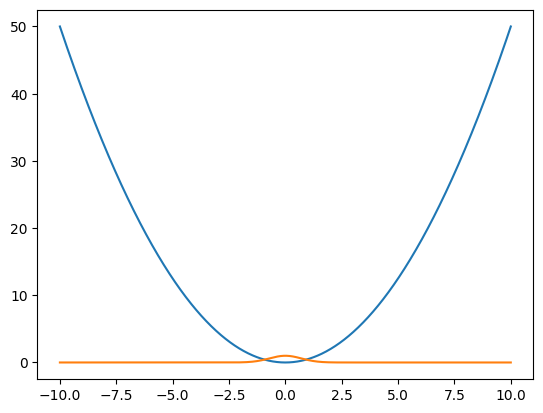

In [ ]:
#Defining the potential
def V(x):
  return 0.5*x**2

x = torch.linspace(-10,10,1000).view(-1,1)
pot = V(x)

plt.plot(x,pot)
plt.plot(x, np.exp(-(x)**2))
plt.show()

In [ ]:
#Defining the NN architecture
class RqNN(torch.nn.Module):
  def __init__(self,layers):
    super(RqNN,self).__init__()
    self.activation = sine()

    #Defining the Layers
    self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers) - 1)])

    #Initializing the weights
    for i in range(len(layers)-1):
      nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
      nn.init.zeros_(self.linears[i].bias.data)


  #Defining the forward pass
  def forward(self,x):
    if torch.is_tensor(x) != True:
      x = torch.from_numpy(x)
    a = x.float()
    #In1 = self.ein(torch.ones_like(a))
    for i in range(len(self.linears)-1):
      z = self.linears[i](a)
      a = self.activation(z)

    a = self.linears[-1](a)
    return a

In [ ]:
#Defining the hyperparameters
t0 =-10; tf = 10; xbc = 0
col_pts = 201; layers = [1,100,100,1]; lr = 1e-2; epochs =100000

In [ ]:
def save_checkpoint(state, filename='last_checkpoint_qos.pth.tar'):
  print('=========================')
  print('Saving checkpoint')
  print('=========================')
  torch.save(state, filename)

In [ ]:
model = RqNN(layers)
model.to(device)
print(model)
params = list(model.parameters())
#print(params)
betas = [0.999, 0.9999]
optimizer = optim.Adam(model.parameters(), lr=lr, betas=betas)
#optimizer = optim.LBFGS(model.parameters(), lr=lr, max_iter=10, history_size = 10)
#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor = 0.5, patience = 10, verbose = True)

RqNN(
  (activation): sine()
  (linears): ModuleList(
    (0): Linear(in_features=1, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=100, bias=True)
    (2): Linear(in_features=100, out_features=1, bias=True)
  )
)


#### NN Definition

In [ ]:
def nn_train(NN,t0,tf,xbc,col_pts,epochs,t):
  En_history = [] #To store the eigenvalues as it is optimized
  loss_dic = {} #To store the losses
  loss_dic['pde_loss_hist'] = []; loss_dic['NT_hist'] = []; loss_dic['ortho_loss_hist'] = [];
  loss_dic['loss_hist'] = []; loss_dic['en_loss_hist'] = []; rm_hist = []; iter_store = [pred]
  t_rand = t[torch.randperm(t.shape[0])].to(device) #Reshufflinig the collocation points
  grid = t.to(device) #predictor collocation points
  grid.requires_grad =True
  t_rand.requires_grad =True

  load_model = False #To load the model from the last checkpoint
  window = 500 #For rolling mean
  orth_counter = 0
  En_counter = []
  #Dictionary for storing the learned eigenfunction
  dic = {}

  stime = time.time()
  if load_model:
    print('=========================')
    print('Loading checkpoint')
    print('=========================')
    checkpoint = torch.load('last_checkpoint_qos.pth.tar')
    NN.load_state_dict(checkpoint['state_dict']); optimizer.load_state_dict(checkpoint['optimizer'])
    current = checkpoint['epoch']; orth_counter = checkpoint['orth_counter']; loss_dic = checkpoint['loss_dic']
    En_history = checkpoint['En_history'];dic = checkpoint['dic']; En_counter = checkpoint['En_counter']; iter_store = checkpoint['iter_store']
    print('=========================')
    print('Loaded checkpoint')
    print('=========================')
  else:
    current = -1
  for iter in range(current+1,epochs + 1):
    loss = 0.0
    Vx = V(t_rand.cpu()).to(device)

    if iter < 5000:
      #Getting the parametric solution
      psi = parametricSolutions(grid,NN,t0,tf,xbc).to(device)
      total_loss = hamEqs_Loss1(grid,psi, Vx,iter)
      if iter % 1000 == 0:
        print('--------------------------------------------')
        print('Epoch: ', iter)
        print('loss = ', total_loss.cpu().detach().numpy())
      if iter == 4995:
        checkpoint = {'psi': psi}
        save_checkpoint(checkpoint,'psi.pth.tar')
    else:
      #Getting the parametric solution
      psi = parametricSolutions(t_rand,NN,t0,tf,xbc).to(device)

      #Derivatives needed when computing en_loss
      psi_x = dfx(psi,t_rand)
      psi_xx = dfx(psi_x,t_rand)
      pde_loss, En = hamEqs_Loss1(t_rand,psi, Vx,iter)
      En_history.append(En.cpu().detach().numpy().item())
      #Getting the loss after the forward pass
      loss_dic['pde_loss_hist'].append(pde_loss.cpu().detach().numpy())

      criteria_loss = pde_loss


      #Adding the normalization as a regularization term
      NT = ( 1 - ((tf - t0) * torch.sqrt(torch.dot(psi[:,0],psi[:,0]))/ col_pts) ).pow(2)
      total_loss = NT  + criteria_loss
      #Storing the losses
      loss_dic['NT_hist'].append(NT.cpu().detach().numpy())

      #Defining the Rolling Mean Error estimate
      if len(En_history) > window:
        rmean = np.mean(np.array(En_history[-window:])-np.array(En_history[-window-1:-1]))
      else:
        rmean = np.mean(np.array(En_history[1:])-np.array(En_history[:-1]))


      #Storing the rm after each epoch
      rm_hist.append(rmean)

      #Defining the minimum training
      iter_diff = iter - iter_store[-1]


      if abs(rmean) <1e-8 and iter_diff > window + 1:
        dic[orth_counter] = copy.deepcopy(NN)
        iter_store.append(iter)
        En_counter.append(En_history[-1])
        orth_counter += 1
        print('==========================================')
        print(f"Learned {orth_counter} Eigenvalues")
        print('==========================================')
        #saving a checkpoint for future iterations
        checkpoint = {
            'state_dict': NN.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': iter, 'loss_dic': loss_dic,
            'orth_counter': orth_counter, 'En_history': En_history, 'dic': dic, 'En_counter': En_counter,
            'iter_store': iter_store
        }
        save_checkpoint(checkpoint)


      #Calculating condition for the orthogonality loss
      #Getting the condition for the en_loss
      if orth_counter > 0:
        diff = ((torch.dot(psi[:,0], -0.5*psi_xx[:,0] + Vx[:,0] * psi[:,0]))/(torch.dot(psi[:,0],psi[:,0]))) - En_counter[-1]
        #en_loss = 0 if diff > 0 else 5*torch.exp(-diff)
        en_loss = 5*torch.clamp(torch.sign(-diff), min=0)*torch.exp(-diff)
        ortho_loss = 0

        #Normalizing the orthogonal loss
        for i in range(orth_counter):
          psi_i = parametricSolutions(t_rand,dic[i],t0,tf,xbc)[:,0]
          ortho = torch.sqrt(torch.dot(psi_i, psi[:,0]).pow(2))/ (torch.sqrt(torch.dot(psi_i, psi_i) * torch.sqrt(torch.dot(psi[:,0], psi[:,0]))))
          ortho_loss += ortho

        total_loss +=  ortho_loss/3.5 + en_loss
        #Saving the remaining losses
        loss_dic['ortho_loss_hist'].append(ortho_loss.cpu().detach().numpy())
        loss_dic['en_loss_hist'].append(en_loss.cpu().detach().numpy())


      if iter % 300 == 0:
        print('--------------------------------------------')
        print(f'Epoch: {iter}')
        print(f'En: {En_history[-1]}')
        print(f'oc: {orth_counter}')
        print('--------------------------------------------')
        print('Total_loss: ',total_loss.cpu().detach().numpy())
        print('rm: ', rmean)
        if orth_counter > 0:
          print('ortho_loss: ', loss_dic['ortho_loss_hist'][-1])
          #print('en_loss: ',loss_dic['en_loss_hist'][-1])
        print('pde_loss: ', criteria_loss.cpu().detach().numpy())
        print('NT: ', loss_dic['NT_hist'][-1])
        #for name, param in NN.named_parameters():
        #  if param.grad is not None:
        #    print(f'Parameter: {name}, Gradient Norm: {torch.norm(param.grad)}')
        if  orth_counter == 6:
          print('==========================================')
          print(f"Completely learned all Eigenvalues")
          break
          print('==========================================')

    #Backward propagation
    optimizer.zero_grad()
    total_loss.backward()
    #Introducing Gradient clipping
    #max_norm =5.0
    #torch.nn.utils.clip_grad_norm_(qNN.parameters(), max_norm)
    optimizer.step()
    loss += total_loss.cpu().detach().numpy()


    #Storing the loss after each iteration
    loss_dic['loss_hist'].append(loss)
    #Scheduling the learning rate
    #scheduler.step(total_loss)


  #Storing the final eigenfunction and eigenvalue
  dic[orth_counter] = copy.deepcopy(NN)
  En_counter.append(En_history[-1])


  ftime = time.time()
  ttime = (ftime - stime)/60
  print(f'Total training time is {ttime} minutes')
  return loss_dic, En_history, En_counter, dic, rm_hist, iter_store

#### Training

In [ ]:
x_lhs = torch.tensor(t0 + (tf - t0)*lhs(1,col_pts)).view(-1,1).float()
x_lhs.shape

torch.Size([201, 1])

In [ ]:
#x_uniform = torch.linspace(t0,tf,col_pts).view(-1,1)
Loss, eig_vals, eig_count, qPINN, rm_hist, iter_store = nn_train(model,t0,tf,xbc,col_pts,epochs,x_lhs)

--------------------------------------------
Epoch:  0
loss =  0.8942476
--------------------------------------------
Epoch:  1000
loss =  0.0102378465
--------------------------------------------
Epoch:  2000
loss =  0.0022869352
--------------------------------------------
Epoch:  3000
loss =  0.0010996569
--------------------------------------------
Epoch:  4000
loss =  0.00035987512
Saving checkpoint


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


--------------------------------------------
Epoch: 5100
En: 0.544440746307373
oc: 0
--------------------------------------------
Total_loss:  0.1159492
rm:  -0.0016094362735748291
pde_loss:  0.11197
NT:  0.003979201
--------------------------------------------
Epoch: 5400
En: 0.5289779305458069
oc: 0
--------------------------------------------
Total_loss:  0.037427027
rm:  -0.0004410161077976227
pde_loss:  0.03692284
NT:  0.00050418853
--------------------------------------------
Epoch: 5700
En: 0.4936446249485016
oc: 0
--------------------------------------------
Total_loss:  0.019596882
rm:  -0.00011966961622238159
pde_loss:  0.01879725
NT:  0.0007996314
--------------------------------------------
Epoch: 6000
En: 0.5065039396286011
oc: 0
--------------------------------------------
Total_loss:  0.014437915
rm:  -7.044339179992676e-05
pde_loss:  0.0142602185
NT:  0.00017769639
--------------------------------------------
Epoch: 6300
En: 0.5043670535087585
oc: 0
--------------------

In [ ]:
checkpoint = torch.load('last_checkpoint_qos.pth.tar')
Loss = checkpoint['loss_dic']; En_counter = checkpoint['En_counter']; dic = checkpoint['dic'];
iter_store = checkpoint['iter_store']; En_history = checkpoint['En_history']

<ipython-input-15-a9288b1e511d>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('last_checkpoint_qos.pth.tar')


In [ ]:
iter_store = np.array(iter_store)
iter_store - iter_store[0]

array([    0,  1752,  3519,  6295,  8991, 11043, 13868])

In [ ]:
diff_iter = [iter_store[i+1] - iter_store[i] for i in range(len(iter_store)-1)]
diff_iter

[1752, 1767, 2776, 2696, 2052, 2825]

In [ ]:
En_counter

[0.5014029145240784,
 1.5031195878982544,
 2.500549554824829,
 3.500577688217163,
 4.503879547119141,
 5.49891471862793]

In [ ]:
exact = [i+0.5 for i in range(len(En_counter))]
exact

[0.5, 1.5, 2.5, 3.5, 4.5, 5.5]

In [ ]:
relative_err = np.abs((np.array(En_counter) - np.array(exact)))/np.abs(np.array(exact))
relative_err

array([0.00280583, 0.00207973, 0.00021982, 0.00016505, 0.00086212,
       0.00019732])

In [ ]:
#Average training time for each eigenpair
np.mean(np.array(iter_store[1:])- np.array(iter_store[:-1]))

2311.3333333333335

In [ ]:
tTest = torch.linspace(-10,10,1200).view(-1,1)
tTest.requires_grad=True
t_net = tTest.detach().numpy()
psi = {}
#psi1 =parametricSolutions(tTest,dic[0].cpu(),t0,tf,xbc).data.numpy()
#psi2 =parametricSolutions(tTest,dic[1].cpu(),t0,tf,xbc).data.numpy()
#psi3 = parametricSolutions(tTest,dic[2].cpu(),t0,tf,xbc).data.numpy()
for i in range(len(dic)):
  psi[i] = parametricSolutions(tTest,dic[i].cpu(),t0,tf,xbc).data.numpy()

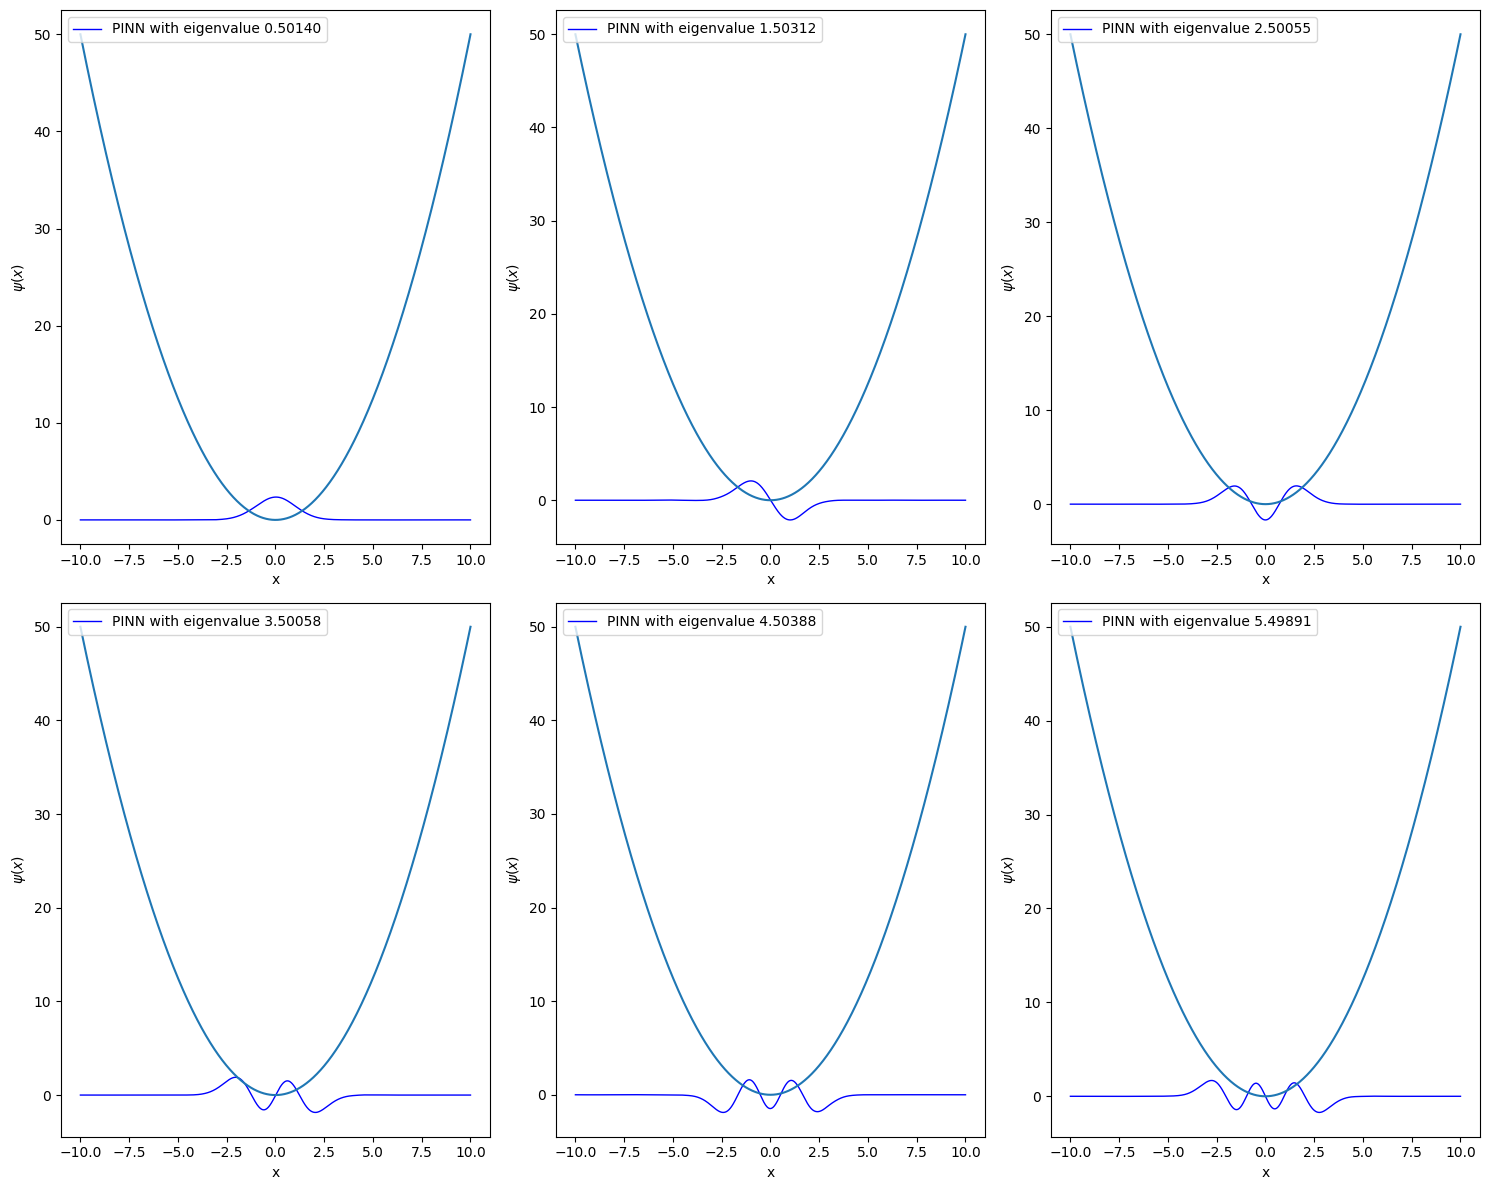

In [ ]:
#Defining the number of rows and columns for the subplot grid
num_rows = 2
num_cols = 3

# Calculate the total number of subplots needed
total_subplots = len(psi)

# Create a figure and axes for the subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 12))

# Iterate over eigenvalues and corresponding solutions
for index, eig in enumerate(En_counter[:total_subplots]):
    row_index = index // num_cols  # Calculate row index
    col_index = index % num_cols   # Calculate column index

    # Plot on the corresponding subplot
    #psi_i = psi[index] + En_counter[index]
    ax = axes[row_index, col_index]
    ax.plot(t_net, psi[index], color='blue', linewidth=1, label=f'PINN with eigenvalue {En_counter[index]:.5f}')
    ax.plot(t_net, V(torch.tensor(t_net)).numpy())
    ax.set_xlabel('x', color='black')
    ax.set_ylabel('$\psi(x)$', color='black')
    ax.tick_params(axis='y', color='black')
    ax.legend(loc = 'upper left')

# Hide the unused subplot
if total_subplots < num_rows * num_cols:
    for i in range(total_subplots, num_rows * num_cols):
        fig.delaxes(axes.flat[i])
# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


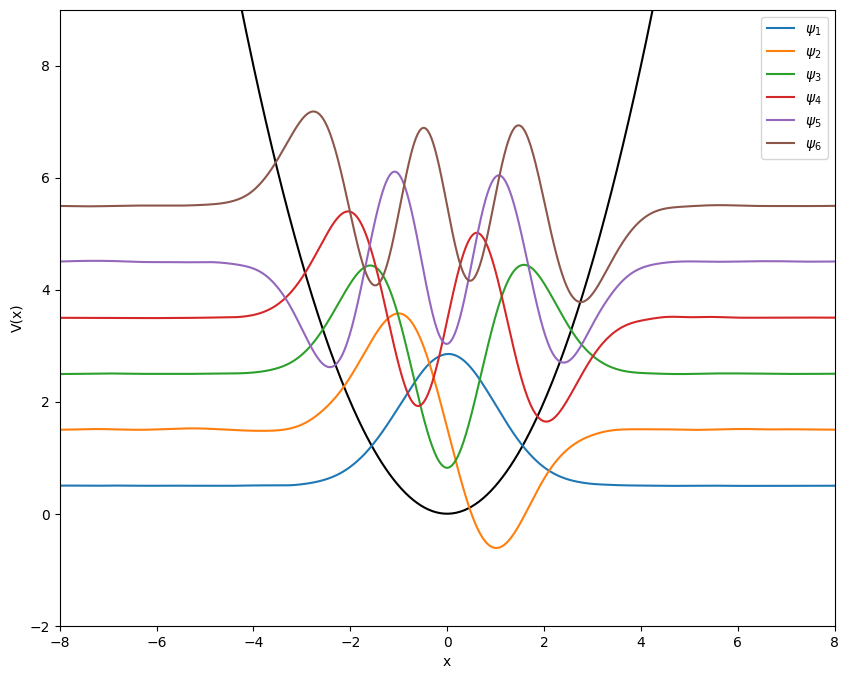

In [ ]:
fig, ax1 = plt.subplots(figsize = (10,8))
x = torch.linspace(-8,8,400).view(-1,1)
pot = V(x)
ax1.plot(x,pot, 'k')
ax1.plot(t_net, En_counter[0]+psi[0], label ='$\psi_{1}$')
ax1.plot(t_net, En_counter[1]+psi[1], label ='$\psi_{2}$')
ax1.plot(t_net, En_counter[2]+psi[2], label ='$\psi_{3}$')
ax1.plot(t_net, En_counter[3]+psi[3], label ='$\psi_{4}$')
ax1.plot(t_net, En_counter[4]+psi[4], label ='$\psi_{5}$')
ax1.plot(t_net, En_counter[5]+psi[5], label ='$\psi_{6}$')
ax1.set_ylim(-2,9); ax1.set_xlim(-8,8)

plt.xlabel('x'); plt.ylabel('V(x)')
plt.legend()
plt.show()

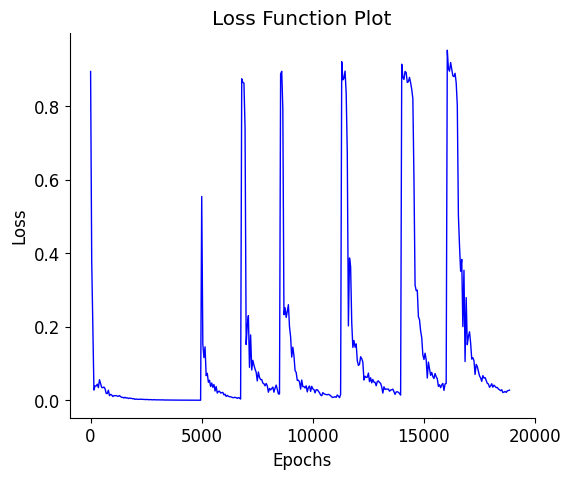

In [ ]:
plt.rcParams.update({'font.size': 12})
#Plotting the loss function
loss = np.array(Loss['loss_hist'][::50]); ep = np.linspace(0,iter_store[-1],loss.shape[0])

fig, ax1 = plt.subplots(figsize=(6, 5))
ax1.plot(ep, loss, color='blue', linewidth=1, label='Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_xticks([0, 5000, 10000, 15000, 20000])
ax1.tick_params(axis='y', color='black')

ax1.set_title('Loss Function Plot')

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

plt.show()

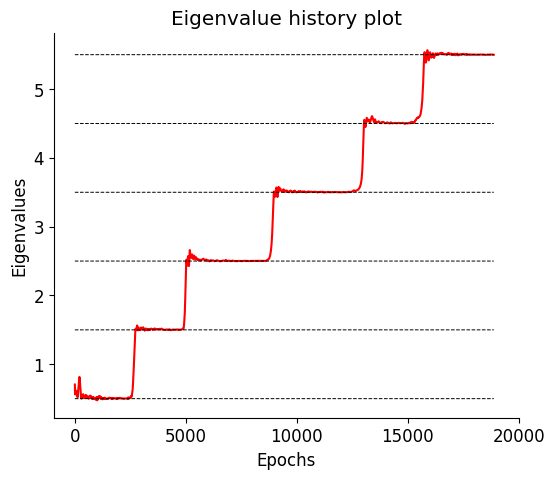

In [ ]:
#Plotting the energy levels
Exact = [i+0.5 for i in range(len(En_history))]


en = np.array(En_history); ep = np.linspace(0,iter_store[-1],en.shape[0])
fig, ax1 = plt.subplots(figsize=(6, 5))
ax1.plot(ep, en, color='red')
ax1.plot(ep, Exact[0]*np.ones(len(ep)),'--k', linewidth = 0.7)
ax1.plot(ep, Exact[1]*np.ones(len(ep)),'--k', linewidth = 0.7)
ax1.plot(ep, Exact[2]*np.ones(len(ep)),'--k', linewidth = 0.7)
ax1.plot(ep, Exact[3]*np.ones(len(ep)),'--k', linewidth = 0.7)
ax1.plot(ep, Exact[4]*np.ones(len(ep)),'--k', linewidth = 0.7)
ax1.plot(ep, Exact[5]*np.ones(len(ep)),'--k', linewidth = 0.7)
ax1.set_xlabel('Epochs')
ax1.set_xticks([0, 5000, 10000, 15000, 20000])
ax1.set_ylabel('Eigenvalues')

ax1.set_title('Eigenvalue history plot')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)


plt.show()

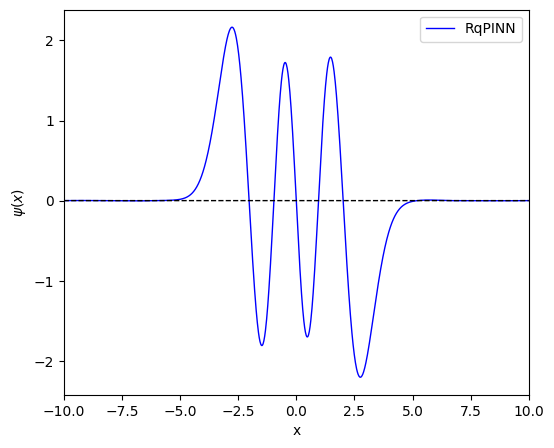

In [ ]:
fig, ax1 = plt.subplots(figsize=(6,5))
ax1.plot(t_net, psi[5], color='blue', linewidth=1, label=f'RqPINN')
ax1.plot(t_net, np.zeros(len(t_net)),'--k', linewidth=1)
ax1.set_xlabel('x',color='black')
ax1.set_ylabel('$\psi(x)$',color='black')
ax1.tick_params(axis='y', color='black')
ax1.set_xlim(t0,tf)
ax1.legend(loc='upper right')

#plt.grid('on')
plt.show()